## Часть 1: Основные функции для построения дерева(без готовых реализаций)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.stats as sts

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

Реализуем функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием. В качестве меры хаотичности $H(R)$ для задачи регрессии используем дисперсию подвыборки, а для задачи классификации – критерий Джини

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.Series],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:

    def gini_impurity(target_vector):
        _, counts = np.unique(target_vector, return_counts=True)
        probs = counts / len(target_vector)
        gini = 1 - np.sum(probs**2)
        return gini

    def variance(target_vector):
        return np.var(target_vector)

    criterion = gini_impurity if task == "classification" else variance

    q_best = -np.inf
    threshold_best = None
    q_0 = criterion(target_vector)

    if feature_type == "real":
        sorted_idx = np.argsort(feature_vector)
        feature_vector = feature_vector[sorted_idx]
        target_vector = target_vector[sorted_idx]
        thresholds = (feature_vector[:-1] + feature_vector[1:]) / 2
        thresholds = thresholds[sorted_idx][1:-1]
        thresholds = np.unique(thresholds)[1:]

    elif feature_type == "categorical":
        thresholds = np.unique(feature_vector)

    def calc_q(threshold, feature_vector, target_vector, criterion, q_0):
        left_mask = feature_vector < threshold if feature_type == "real" else feature_vector == threshold
        right_mask = ~left_mask
        q_left = criterion(target_vector[left_mask])
        q_right = criterion(target_vector[right_mask])

        q = q_0 - (q_left * np.sum(left_mask) + q_right * np.sum(right_mask)) / len(feature_vector)

        return q

    calc_q = np.vectorize(calc_q, excluded=[1, 2, 3, 4])

    q_values = calc_q(thresholds, feature_vector, target_vector, criterion, q_0)
    threshold_best = thresholds[np.argmax(q_values)]
    q_best = np.max(q_values)

    return thresholds, np.array(q_values), threshold_best, q_best


Начинаем с отсортированного вектора значений признака и целевой переменной.
Вычисляем пороги как среднее между соседними значениями признака.
Для каждого порога вычисляем булеву маску, которая указывает, принадлежит ли каждый элемент к левой части разбиения.
Считаем кумулятивные суммы элементов маски и их квадратов. Это позволяет вычислить индекс Джини для левого разбиения для каждого порога в векторизованной форме.
Повторяем процесс для правого разбиения, считая кумулятивные суммы с конца в начало.
Вычисляем общий индекс Джини для каждого порога, используя формулу, которую мы получили ранее.ё

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведем график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
thresholds, gini_values, best_threshold, best_gini = find_best_split(X['MedInc'], y, task = 'regression', feature_type = 'real')

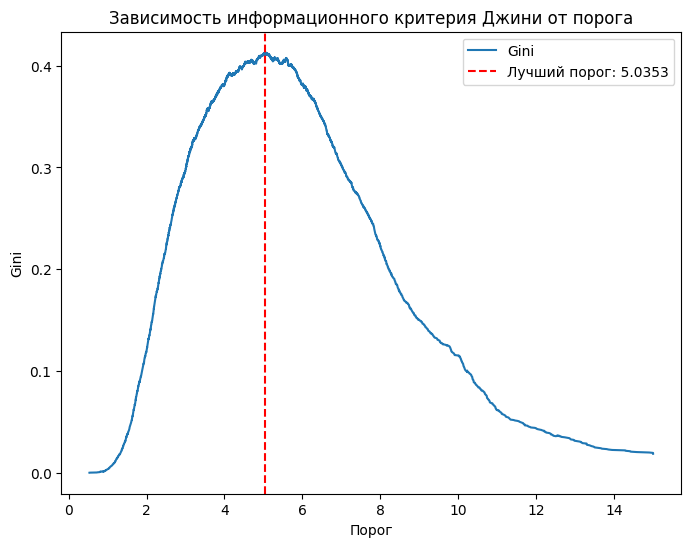

Лучший порог для признака 'MedInc' 5.0353 со значением информационного критерия = 0.41275138620167673


In [ ]:
# Plot Gini values
plt.figure(figsize=(8, 6))
plt.plot(thresholds, gini_values, label="Gini")
plt.axvline(best_threshold, color='r', linestyle='--', label=f"Лучший порог: {best_threshold}")
plt.title("Зависимость информационного критерия Джини от порога")
plt.xlabel("Порог")
plt.ylabel("Gini")
plt.legend()
plt.show()

print(f"Лучший порог для признака 'MedInc' {best_threshold} со значением информационного критерия = {best_gini}")

Найдем лучший предикат первой вершины решающего дерева.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
best_gini = -np.inf
for feature in X.columns:
    thresholds, ginis, threshold_best, gini_best = find_best_split(X[feature], y, task = 'regression', feature_type = 'real')

    if gini_best > best_gini:
        best_gini = gini_best
        best_feature = feature
        best_threshold = threshold_best

print(f"Лучший предикат - '{best_feature} <= {best_threshold}' со значением информационного критерия = {best_gini}")


Лучший предикат - 'MedInc <= 5.0353' со значением информационного критерия = 0.41275138620167673


Реализуем класс `DecisionTree`

Построение дерева осуществляется согласно базовому жадному алгоритму
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.


In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification",
        strategy: str = 'mean'
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self.strategy = strategy

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        if feature_best in self._feature_importances:  # оценка важности
            self._feature_importances[feature_best] += 1
        else:
            self._feature_importances[feature_best] = 1

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        if node['type'] == 'terminal':
            return node['class']

        if self._feature_types[node['feature_split']] == 'real':
            if x[node['feature_split']] < node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        elif self._feature_types[node['feature_split']] == 'categorical':
            if x[node['feature_split']] == node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
            pass

    def fill_na(self, X, strategy='mean'):  # за
        if strategy == 'mean':
            return np.nan_to_num(X, nan=np.nanmean(X))
        elif strategy == 'median':
            return np.nan_to_num(X, nan=np.nanmedian(X))
        elif strategy == 'mode':
            return np.nan_to_num(X, nan=sts.mode(X)[0])
        else:
            raise ValueError("Неизвестный метод")

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = self.fill_na(X, strategy=self.strategy)  # Замена пропусков перед обучением
        self._fit_node(X, y, self._tree)

    def get_feature_importance(self):
        n = sum(self._feature_importances.values())
        for feature, importance in self._feature_importances.items():
            print(f"Признак {feature}: {importance / n:.2f}")

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

 Загрузим таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройм пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируем диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

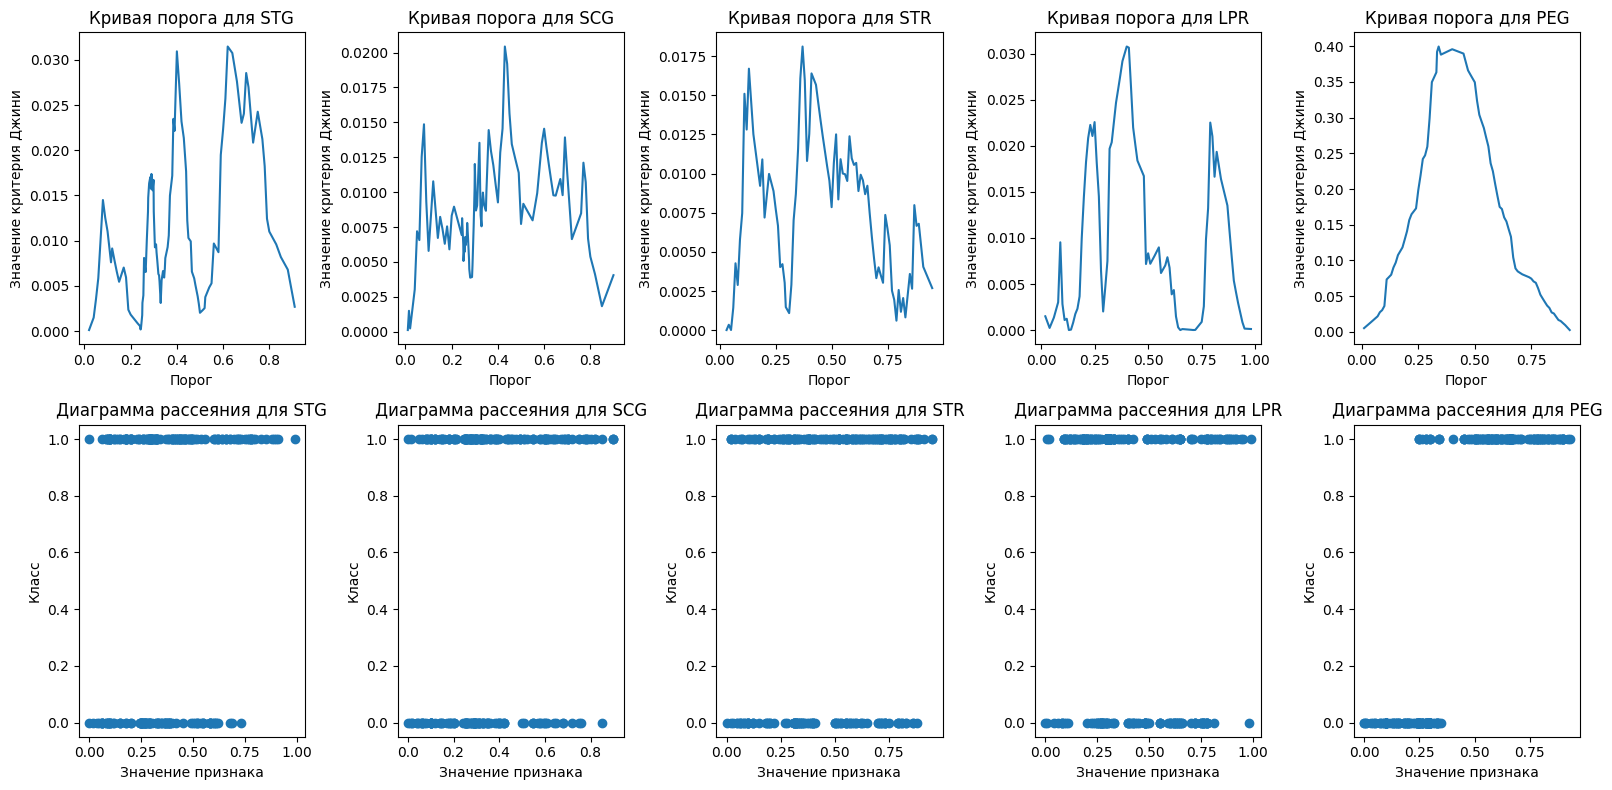

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
data = pd.read_csv('students.csv')

features = data.iloc[:, 1:6]
target = data.iloc[:, -1]

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

for i, feature in enumerate(features.columns):
    thresholds, gini_values, threshold_best, gini_best = find_best_split(features[feature], target)
    axes[0, i].plot(thresholds, gini_values)
    axes[0, i].set_xlabel('Порог')
    axes[0, i].set_ylabel('Значение критерия Джини')
    axes[0, i].set_title(f'Кривая порога для {feature}')

for i, feature in enumerate(features.columns):
    axes[1, i].scatter(features[feature], target)
    axes[1, i].set_xlabel('Значение признака')
    axes[1, i].set_ylabel('Класс')
    axes[1, i].set_title(f'Диаграмма рассеяния для {feature}')

plt.tight_layout()
plt.show()


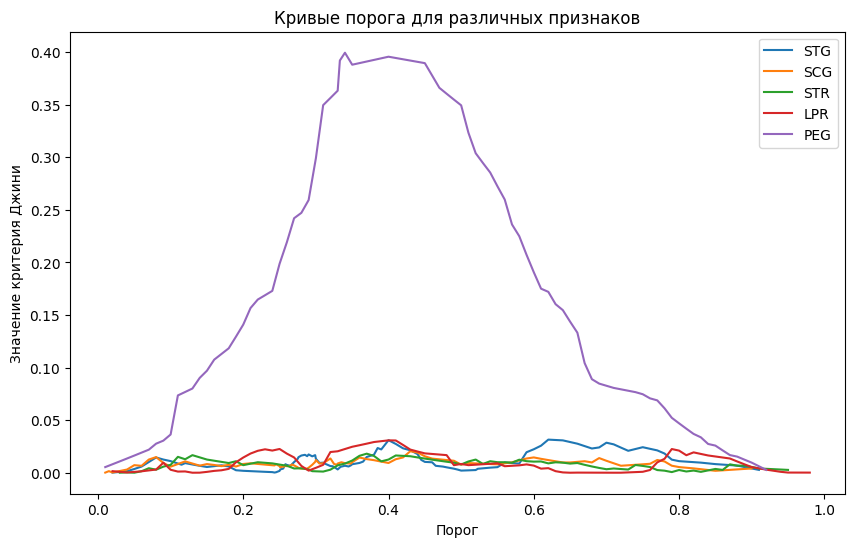

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, feature in enumerate(features.columns):
    thresholds, gini_values, threshold_best, gini_best = find_best_split(features[feature], target)
    ax.plot(thresholds, gini_values, label=feature)

ax.set_xlabel('Порог')
ax.set_ylabel('Значение критерия Джини')
ax.set_title('Кривые порога для различных признаков')
ax.legend()

plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Исходя из кривых значений критерия Джини, нужно производить деление по признаку `PEG`, так как при определенном значении порога достигается максимальное значение информационного критерия.

Этот вывод согласуется с визуальной оценкой диаграмм рассеяния, так как если мы посмотрим на них, то увидим, что для всех признаков, кроме `PEG`, отсутствует четкое разделение. Для `PEG` начиная со значения $\approx$ `0.4` объекты относятся к классу `1`.

Заметим, что для "хороших" признаков кривая значений критерия имеет отчетливый максимум, возрастает примерно до половины порогов, и убывает далее.

Если кривая не имеет отчетливых максимумов и колеблятся в маленьком диапазоне(как кривые не для `PEG`), то по ним деление практически невозможно.

Протестируйем  решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
data = pd.read_csv('agaricus-lepiota.data', header=None)

le = LabelEncoder()
data = data.apply(le.fit_transform)

X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

tree = DecisionTree(feature_types=['categorical']*X_train.shape[1])
tree.fit(X_train.values, y_train.values)

y_pred = tree.predict(X_test.values)

accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


Magnificent

In [ ]:
tree.get_feature_importance()

Признак 4: 0.20
Признак 19: 0.07
Признак 2: 0.07
Признак 14: 0.07
Признак 0: 0.07
Признак 1: 0.07
Признак 12: 0.07
Признак 7: 0.13
Признак 3: 0.13
Признак 10: 0.13


# Часть 2: Бэггинг и случайный лес (4 балла)
В данной части мы будем работать с задачей предсказания диабета у пациента. Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

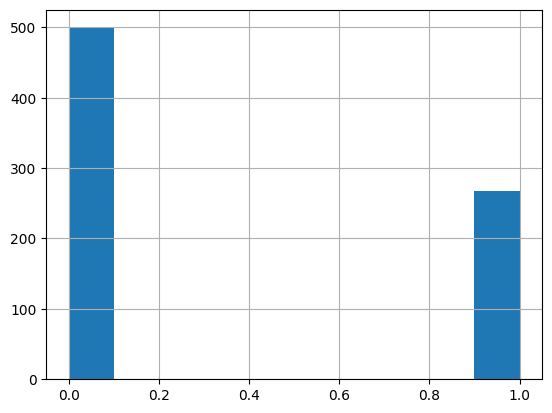

In [ ]:
data['Outcome'].hist()
plt.show()

видно, что классов `0` больше, но не сильно

Разделим данные на трейн/вал/тест

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


На обучающей-валидационной выборке подберем оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`.
Будем жадно перебирать и оценивать качество по f1-мере

Обучим итоговое решающее дерево на **полной обучающей** выборке.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
max_depth_values = [None] + list(range(2,11))
min_samples_leaf_values = list(range(1,17))

best_max_depth, best_min_samples_leaf, best_f1 = None, None, -np.inf

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train_train, y_train_train)

        y_pred = dt.predict(X_train_val)
        f1 = f1_score(y_train_val, y_pred)

        if f1 > best_f1:
            best_max_depth, best_min_samples_leaf, best_f1 = max_depth, min_samples_leaf, f1
best_max_depth, best_min_samples_leaf

(7, 7)

In [ ]:
dt_best = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
dt_best.fit(X_train, y_train)

y_pred = dt_best.predict(X_test)

print('accuracy = ', accuracy_score(y_test, y_pred))
print('precision = ', precision_score(y_test, y_pred))
print('recall = ', recall_score(y_test, y_pred))
print('auc_roc = ', roc_auc_score(y_test, y_pred))

accuracy =  0.696969696969697
precision =  0.5555555555555556
recall =  0.625
auc_roc =  0.6800496688741722


Accuracy около 0.70. Это значит, что 70% от общего количества предсказаний были верными.

Precision около 0.56. Это значит, что из всех объектов, которые были предсказаны как положительными, 56% действительно были ими.

Recall 0,625. Это значит, что из всех положительных объектов 62,5% были правильно предсказаны.

AUC-ROC около 0.68. Чем ближе к 1, тем лучше. 0.68 нормальное значение, но не сильно выдающееся(то же можно сказать про остальные метрики.). Предсказывает лучше случайного классификатора, и то хорошо.

Обучим [`BaggingClassifier`] на 50 деревьях на **полной обучающей** выборке.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

y_pred = bagging_clf.predict(X_test)

print('accuracy = ', accuracy_score(y_test, y_pred))
print('precision = ', precision_score(y_test, y_pred))
print('recall = ', recall_score(y_test, y_pred))
print('auc_roc = ', roc_auc_score(y_test, y_pred))

accuracy =  0.7489177489177489
precision =  0.6309523809523809
recall =  0.6625
auc_roc =  0.7286009933774835


Accuracy около 0.75.Значение этой метрики увеличилось на 0.05, примерно на 10% - хороший результат

Precision около 0.63. Значение этой метрики увеличилось на 0.7, больше чем на 10% - хороший результат

Recall 0.6625. Стала больше на 0.04, меньше чем на 10%.

AUC-ROC около 0.73. Стал больше на 0.05, чуть меньше 10%.

Значения всех метрик улучшились, значит эта модель лучше(но не сильно)

Выполним кросс-валидацию на полной обучающей выборке и подберем оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями.


### С помощью GridSearchCV

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
max_depth_values = [None] + list(range(1, 11))
min_samples_split_values = range(2, 11)

# словарь для перебора параметров
parameters = {'max_depth': max_depth_values, 'min_samples_split': min_samples_split_values}

gs = GridSearchCV(RandomForestClassifier(n_estimators=50, random_state=42), parameters, scoring='f1', cv=5)
gs.fit(X_train, y_train)

print(gs.best_params_)

rfc = RandomForestClassifier(n_estimators=50, max_depth=gs.best_params_['max_depth'], min_samples_split=gs.best_params_['min_samples_split'], random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

print('accuracy = ', accuracy_score(y_test, y_pred))
print('precision = ', precision_score(y_test, y_pred))
print('recall = ', recall_score(y_test, y_pred))
print('auc_roc = ', roc_auc_score(y_test, y_pred))

{'max_depth': 8, 'min_samples_split': 3}
accuracy =  0.7359307359307359
precision =  0.6091954022988506
recall =  0.6625
auc_roc =  0.7186672185430463


Accuracy около 0.74. Чуть меньше чем у беггинга

Precision около 0.61. Аналогично

Recall 0.6625. У беггинга так же

AUC-ROC около 0.72. Чуть меньше чем у беггинга

По сравнению с моделью на основе бэггинга, случайный лес показал немного более низкую точность и AUC-ROC, но такую же полноту - беггинг лучше. Это может быть связано с тем, что случайный лес добавляет дополнительный элемент случайности в процесс обучения, что может привести к улучшению производительности, но также иногда приводит к более плохим результатам по сравнению с бэггингом.

### Без GridSearchCV

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————  - без GridSearchCV
from sklearn.model_selection import cross_val_score
max_depth_values = [None] + list(range(1, 11))
min_samples_split_values = range(2, 11)

best_f1 = 0
best_max_depth = None
best_min_samples_split = None

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        rfc = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_split=min_samples_split, random_state = 42)

        scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='f1')
        average_f1 = scores.mean()
        if average_f1 > best_f1:
            best_f1 = average_f1
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split

In [ ]:
best_rfc = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state = 42)
best_rfc.fit(X_train, y_train)

y_pred = best_rfc.predict(X_test)

print(f'max_depth = {best_max_depth}, min_samples_split = {best_min_samples_split}')
print('accuracy = ', accuracy_score(y_test, y_pred))
print('precision = ', precision_score(y_test, y_pred))
print('recall = ', recall_score(y_test, y_pred))
print('auc_roc = ', roc_auc_score(y_test, y_pred))

max_depth = 8, min_samples_split = 3
accuracy =  0.7359307359307359
precision =  0.6091954022988506
recall =  0.6625
auc_roc =  0.7186672185430463


То же самое, что и с GridSearchCV

Построим график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса

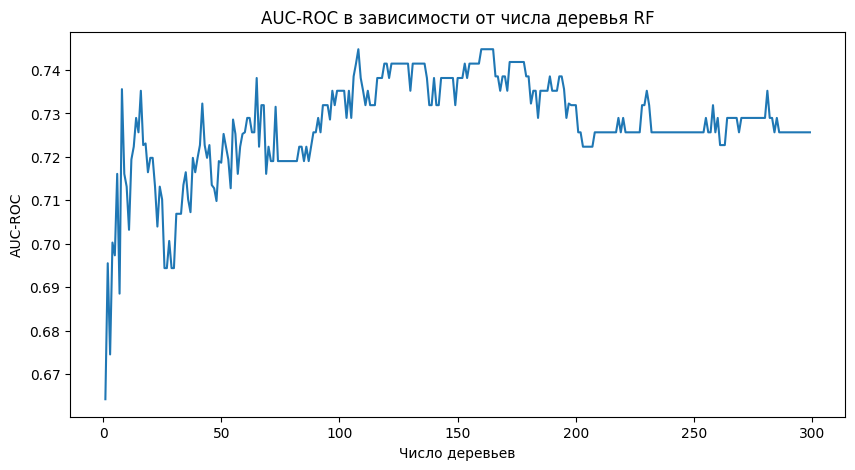

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
auc_roc_values = []

for n_estimators in range(1, 300):
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    auc_roc_values.append(roc_auc_score(y_test, y_pred))

plt.figure(figsize=(10, 5))
plt.plot(range(1,300), auc_roc_values)
plt.xlabel('Число деревьев')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC в зависимости от числа деревья RF')
plt.show()

AUC-ROC, выходит на асимптоту(примерно) при увеличении числа деревьев, указывает на то, что после определенного значения увеличение числа деревьев в случайном лесе не приводит к существенному улучшению качества модели.

Видим, что максимальный AUC-ROC достигается при n $\approx$ 100, а потом только уменьшаетс и выходит на асимптоту.


Для лучшей модели посмотрим на feature importance

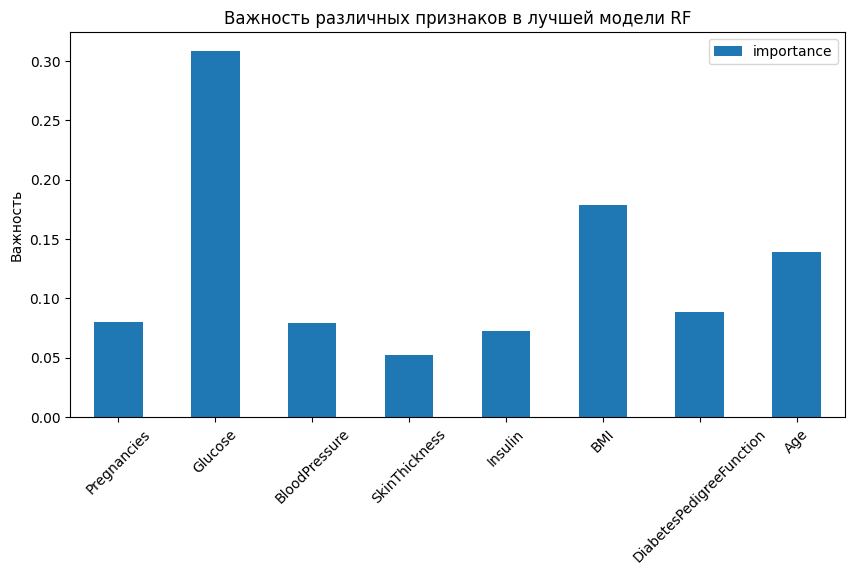

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
feature_importances = best_rfc.feature_importances_
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})

importances_df.plot(kind='bar', x='feature', y='importance', figsize=(10, 5))
plt.title('Важность различных признаков в лучшей модели RF')
plt.ylabel('Важность')
plt.xlabel('')
plt.xticks(rotation = 45)
plt.show()

признак `Glucose` оказался самым важным для определения диабета!